# Preparation

## Import packages

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from importlib import reload
import json
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import patch_seq_spl.helper_functions as src
from utility.ryp import r, to_r

Loading required package: svglite


In [5]:
r(
"""
options(warn=-1)
library(readr)
library(ggplot2)
library(magrittr)
library(dplyr)
library(tidyr)
library(ggvenn)
"""
)

## Import ExtendedAnnData objects and glm_results


In [3]:
glm_results = src.get_glm_results("proc/scquint/three/simple")

# Venn Diagrams

In [6]:
glm_results.glm.rank_introns_by_n_sig_corr("all", True, True).to_csv("sig_VGIC_SJ.csv")

In [7]:
def intersect_lists(lists):
    if isinstance(lists, dict):
        lists = lists.values()
    return set.intersection(*map(set, lists))

def union_lists(lists):
    if isinstance(lists, dict):
        lists = lists.values()
    return set.union(*map(set, lists))

def get_sig_introns_dict(glm_results, predictor_list, VGIC_only):
    '''
    Given a list of predictors, return a dictionary of significant introns for each predictor
    '''
    return {subclass_name: glm_results.glm.rank_introns_by_n_sig_corr(subclass_name, VGIC_only, True).index.to_list() for subclass_name in predictor_list}

def plot_ggvenn(glm_results, predictor_list, VGIC_only):
    '''
    Given a list of predictors, plot the venn diagram of significant introns for each predictor
    '''
    my_dict = get_sig_introns_dict(glm_results, predictor_list, VGIC_only)
    to_r(my_dict, "my_dict")
    r("ggvenn(my_dict)")


The intersrction between unions of subclass-associated and ephys-associated splice junctions

null device 
          1 


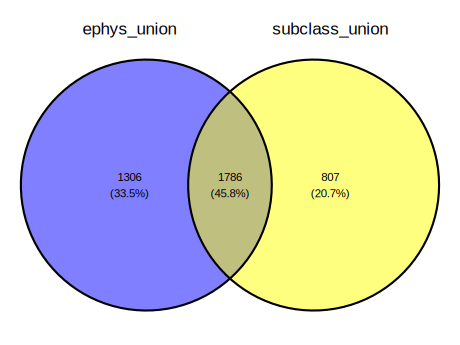

In [8]:
VGIC_only = False
subclass_list = ["Vip", "Sst", "Pvalb", "Lamp5", "Sncg", "Serpinf1"]

ephys_union = glm_results.glm.rank_introns_by_n_sig_corr("ephys_prop", VGIC_only=VGIC_only, sig_only=True).index.to_list()
subclass_union = list(union_lists(get_sig_introns_dict(glm_results, subclass_list, VGIC_only)))
my_dict = {"ephys_union": ephys_union, "subclass_union": subclass_union}
to_r(my_dict, "my_dict")
r("ggvenn(my_dict)")

The intersection between splice junction predicted by each subclass and union of ephys-assocaited splice junctions

null device 
          1 


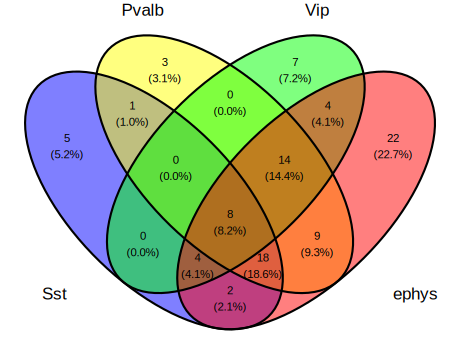

In [10]:
VGIC_only = True

my_dict = get_sig_introns_dict(glm_results, ["Sst", "Pvalb", "Vip"], VGIC_only=VGIC_only)
ephys_union = glm_results.glm.rank_introns_by_n_sig_corr("ephys_prop", VGIC_only=VGIC_only, sig_only=True).index.to_list()
my_dict["ephys"] = ephys_union

to_r(my_dict, "my_dict")
r("ggvenn(my_dict)")

null device 
          1 


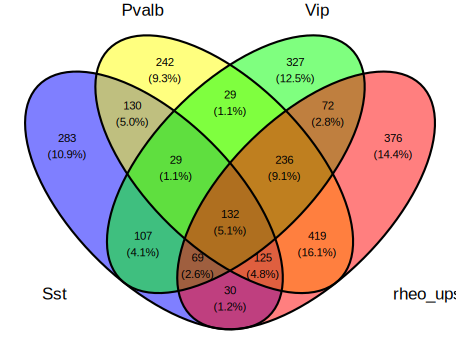

In [11]:
VGIC_only = False

subclass_list = ['Sst', 'Pvalb', 'Vip', 'rheo_upstroke_downstroke_ratio']
plot_ggvenn(glm_results, subclass_list, VGIC_only=VGIC_only)

# Proportions of sig genes that are ion channels

In [33]:
ephys_props = pd.read_csv("data/ephys_data_sc.csv", index_col = 0).columns
n_sig_gene_in_VGIC = [len(glm_results.glm.get_sig_gene_list(predictor, VGIC_only=True)) for predictor in glm_results.columns]
n_sig_gene = [len(glm_results.glm.get_sig_gene_list(predictor, VGIC_only=False)) for predictor in glm_results.columns]

null device 
          1 


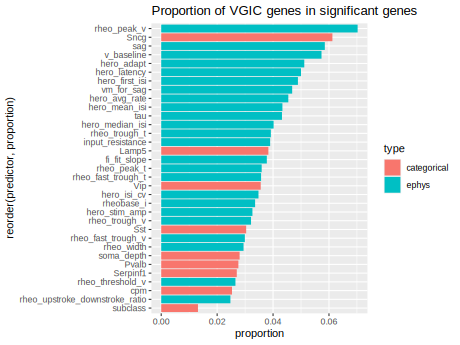

In [34]:
VGIC_prop = pd.Series((np.array(n_sig_gene_in_VGIC) / np.array(n_sig_gene)), index=glm_results.columns, name="proportion")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
to_r(VGIC_prop, "VGIC_prop")
r(
"""
VGIC_prop %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = proportion, y = reorder(predictor, proportion), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of VGIC genes in significant genes")
"""
  )

null device 
          1 


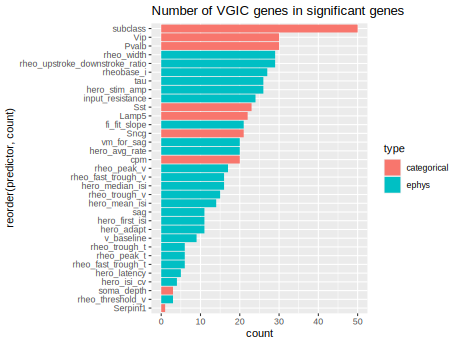

In [35]:
VGIC_count = pd.Series(n_sig_gene_in_VGIC, index = glm_results.columns, name = "count")\
    .to_frame()\
    .assign(type = lambda x: np.where(x.index.isin(ephys_props), "ephys", "categorical"))
to_r(VGIC_count, "VGIC_count")
r(
"""
VGIC_count %>% 
  as_tibble(rownames = "predictor") %>% 
  mutate(type = as.factor(type)) %>% 
  ggplot(aes(x = count, y = reorder(predictor, count), fill = type)) +
    geom_bar(stat = "identity") +
    ggtitle("Number of VGIC genes in significant genes")
"""
  )    

In [ ]:
subclass_individually = set(src.get_sig_gene_list(glm_results, "Vip"))\
    .union(*[set(src.get_sig_gene_list(glm_results, subclass_name)) for subclass_name in ["Sst", "Pvalb", "Sncg", "Serpinf1"]])
subclass_individually = list(subclass_individually)
to_r(subclass_individually, "subclass_individually")
to_r(src.get_sig_gene_list(glm_results, "subclass"), "subclass")

null device 
          1 


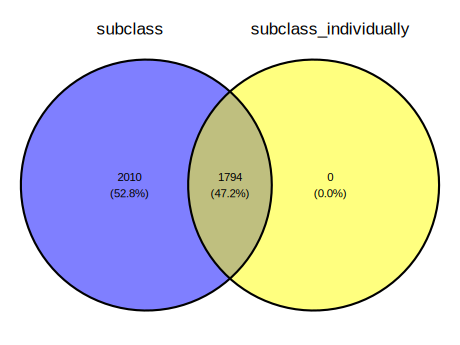

In [ ]:
r(
"""
a <- list(
    subclass = subclass %>% unlist(),
    subclass_individually = subclass_individually %>% unlist())
ggvenn(a)
"""
)

# Number sig clusters that include at least one novel splice site

In [ ]:
adata = anndata.read_h5ad("proc/scquint/preprocessed_adata_three.h5ad")
novel_dict = adata.var\
    .assign(annotation = lambda x: x.annotation.apply({0 : True, 1 : False}.get))\
    .groupby("intron_group")["annotation"].any().to_dict()
temp = glm_results\
    .applymap(lambda x: x < 0.05)\
    .assign(annotation = lambda x: x.index.map(novel_dict))\
    .groupby("annotation")\
    .sum().T\
    .rename(columns = {True : "novel", False : "known"})
to_r(temp, "temp")

null device 
          1 


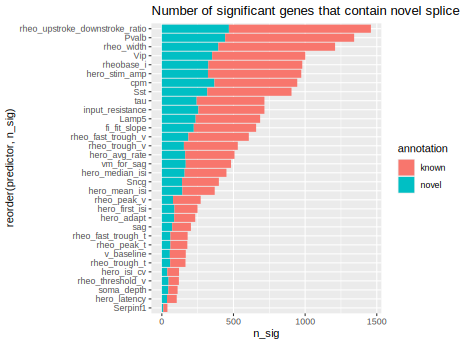

In [ ]:
r(
"""
temp <- temp[-which(rownames(temp) == "subclass"), ]
temp %>%
    as_tibble(rownames = "predictor") %>%
    pivot_longer(cols = c("novel", "known"), names_to = "annotation", values_to = "n_sig") %>%
    ggplot(aes(x = n_sig, y = reorder(predictor, n_sig), fill = annotation)) +
        geom_bar(stat = "identity") +
        ggtitle("Number of significant genes that contain novel splice sites")
"""
)

# Heatmap

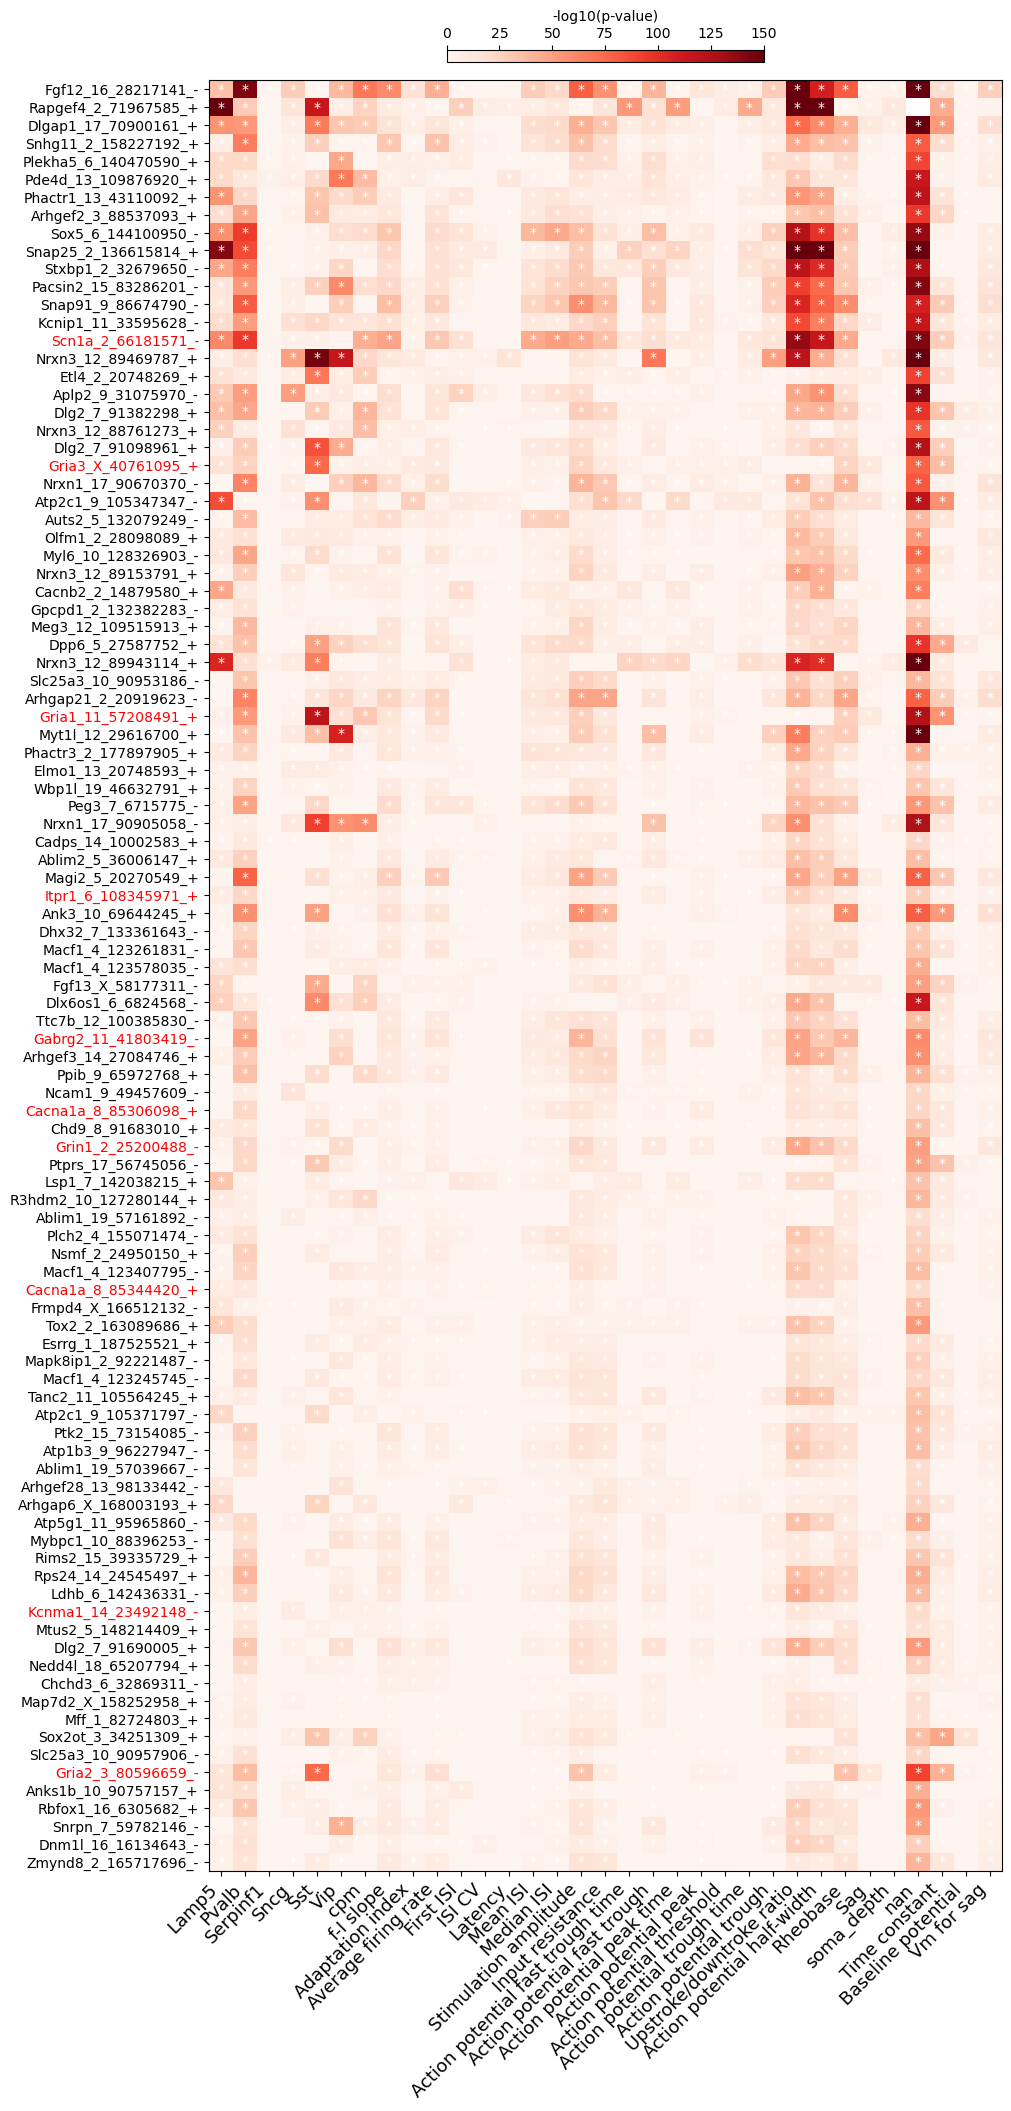

In [ ]:
src.plot_glm_results("proc/scquint/three/simple")